# Utilities

In [1]:
import yfinance as yf
def search_ticker(query):
    stock = yf.Ticker(query)
    info = stock.info
    print(f"Available attributes: {', '.join(info.keys())}")
    
    print(f"Ticker: {query}")
    print(f"Short Name: {info.get('shortName', 'Not Found')}")
    print(f"Long Name: {info.get('longName', 'Not Found')}")
    print(f"Sector: {info.get('sector', 'Not Found')}")
    print(f"Industry: {info.get('industry', 'Not Found')}")
    print(f"Country: {info.get('country', 'Not Found')}")
    print(f"Currency: {info.get('currency', 'Not Found')}")
    print(f"Exchange: {info.get('exchange', 'Not Found')}")
    print(f"Previous Close: {info.get('regularMarketPreviousClose', 'Not Found')}")
    print(f"Market Cap: {info.get('marketCap', 'Not Found')}")
    print("")

In [2]:
# search_ticker("AAPL")
# search_ticker("TSLA")
search_ticker("00631L.TW")

Available attributes: phone, maxAge, priceHint, previousClose, open, dayLow, dayHigh, regularMarketPreviousClose, regularMarketOpen, regularMarketDayLow, regularMarketDayHigh, volume, regularMarketVolume, averageVolume, averageVolume10days, averageDailyVolume10Day, bid, ask, totalAssets, fiftyTwoWeekLow, fiftyTwoWeekHigh, fiftyDayAverage, twoHundredDayAverage, navPrice, currency, ytdReturn, fundFamily, fundInceptionDate, legalType, threeYearAverageReturn, fiveYearAverageReturn, exchange, quoteType, symbol, underlyingSymbol, shortName, longName, firstTradeDateEpochUtc, timeZoneFullName, timeZoneShortName, uuid, messageBoardId, gmtOffSetMilliseconds, trailingPegRatio
Ticker: 00631L.TW
Short Name: YUANTA SECURITIES INV TRUST CO 
Long Name: Yuanta Daily Taiwan 50 Bull 2X ETF
Sector: Not Found
Industry: Not Found
Country: Not Found
Currency: TWD
Exchange: TAI
Previous Close: 207.05
Market Cap: Not Found



# Initialize Spark Session

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, year

spark = SparkSession.builder \
    .appName("Backtesting 00631L Strategy") \
    .getOrCreate()

24/05/15 12:02:39 WARN Utils: Your hostname, Shu-Jengs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
24/05/15 12:02:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/15 12:02:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Prepare data

In [3]:
!pip install yfinance setuptools distlib

  Using cached yfinance-0.2.38-py2.py3-none-any.whl.metadata (11 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached frozendict-2.4.4.tar.gz (315 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached peewee-3.17.5.tar.gz (3.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
Using cached yfinance-0.2.38-py2.py3-none-any.whl (72 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
Using cached requests-2.3

In [7]:
import pandas as pd

def fetch_monthly_data(ticker):
    # Fetch the data
    stock = yf.Ticker(ticker)
    hist = stock.history(period="max")

    # Resample to monthly data
    monthly_data = hist.resample('ME').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()

    return monthly_data

def save_to_csv(data, filename):
    data.to_csv(filename, index=True)

# Fetch and save the data
ticker = "00631L.TW"
monthly_data = fetch_monthly_data(ticker)
save_to_csv(monthly_data, "00631L_monthly_data.csv")

In [9]:
file_path = "00631L_monthly_data.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)
data = data.withColumn("year", year("date"))

# Create a temporary view
data.createOrReplaceTempView("stock_base")

# Register a SQL query to calculate the 12-month moving average partitioned by year
query = """
    SELECT *,
           AVG(close) OVER (ORDER BY date ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS moving_avg
    FROM stock_base
    ORDER BY `year` DESC, Date DESC
"""

# Execute the SQL query
stock_with_moving_avg = spark.sql(query)
stock_with_moving_avg.createOrReplaceTempView("stock_with_moving_avg")

# Show the result
stock_with_moving_avg.show()

+-------------------+------------------+------------------+------------------+------------------+---------+----+------------------+
|               Date|              Open|              High|               Low|             Close|   Volume|year|        moving_avg|
+-------------------+------------------+------------------+------------------+------------------+---------+----+------------------+
|2024-05-31 00:00:00|193.39999389648438|214.35000610351562|             192.0|            212.75| 17211467|2024| 156.4708340962728|
|2024-04-30 00:00:00|196.10000610351562|206.60000610351562|174.35000610351562|196.35000610351562| 77971912|2024| 149.4291674296061|
|2024-03-31 00:00:00|170.89999389648438|198.10000610351562|169.60000610351562|194.64999389648438| 47924380|2024| 142.4708334604899|
|2024-02-29 00:00:00|152.39999389648438|171.10000610351562|151.35000610351562|170.14999389648438| 22536440|2024|136.04166730244955|
|2024-01-31 00:00:00|             152.0| 155.6999969482422|140.3500061035156

24/05/15 12:02:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


# Implement Purchase and Liquidation Logic

In [10]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window

# Add actions using SQL
actions_query = """
    SELECT *,
           CASE
               WHEN close >= moving_avg THEN 'buy'
               WHEN close < moving_avg THEN 'sell'
               ELSE ''
           END AS action,
           0 AS holdings -- Initialize holdings to 0
    FROM stock_with_moving_avg
"""

result_with_actions = spark.sql(actions_query)
result_with_actions.createOrReplaceTempView("stock_with_actions")
# result_with_actions.show(truncate=1000)

# Update holdings based on actions
holdings_query = """
    SELECT *,
           SUM(CASE
                   WHEN action = 'buy' THEN 1
                   WHEN action = 'sell' THEN -1
                   ELSE 0
               END) OVER (ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS holdings
    FROM stock_with_actions
    ORDER BY `year` DESC, Date DESC
"""

result_with_strategy = spark.sql(holdings_query)
result_with_strategy.show(truncate=1000)

+-------------------+------------------+------------------+------------------+------------------+---------+----+------------------+------+--------+--------+
|               Date|              Open|              High|               Low|             Close|   Volume|year|        moving_avg|action|holdings|holdings|
+-------------------+------------------+------------------+------------------+------------------+---------+----+------------------+------+--------+--------+
|2024-05-31 00:00:00|193.39999389648438|214.35000610351562|             192.0|            212.75| 17211467|2024| 156.4708340962728|   buy|       0|      60|
|2024-04-30 00:00:00|196.10000610351562|206.60000610351562|174.35000610351562|196.35000610351562| 77971912|2024| 149.4291674296061|   buy|       0|      59|
|2024-03-31 00:00:00|170.89999389648438|198.10000610351562|169.60000610351562|194.64999389648438| 47924380|2024| 142.4708334604899|   buy|       0|      58|
|2024-02-29 00:00:00|152.39999389648438|171.10000610351562

24/05/15 12:02:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 1

# Calculate Returns

In [11]:
from pyspark.sql.functions import expr

# Calculate returns
returns_query = """
    SELECT *,
           CASE
               WHEN action = 'sell' THEN (close - LAG(close, 1) OVER (PARTITION BY year ORDER BY date)) * holdings
               ELSE 0
           END AS daily_return
    FROM stock_with_actions
    ORDER BY date
"""

result_with_returns = spark.sql(returns_query)
result_with_returns.createOrReplaceTempView("stock_with_returns")

# Calculate cumulative returns
cumulative_returns_query = """
    SELECT *,
           SUM(daily_return) OVER (ORDER BY date) AS cumulative_return
    FROM stock_with_returns
    ORDER BY `year` DESC, Date DESC
"""

result_with_cumulative_returns = spark.sql(cumulative_returns_query)
result_with_cumulative_returns.show(truncate=1000)

+-------------------+------------------+------------------+------------------+------------------+---------+----+------------------+------+--------+------------+-----------------+
|               Date|              Open|              High|               Low|             Close|   Volume|year|        moving_avg|action|holdings|daily_return|cumulative_return|
+-------------------+------------------+------------------+------------------+------------------+---------+----+------------------+------+--------+------------+-----------------+
|2024-05-31 00:00:00|193.39999389648438|214.35000610351562|             192.0|            212.75| 17211467|2024| 156.4708340962728|   buy|       0|         0.0|              0.0|
|2024-04-30 00:00:00|196.10000610351562|206.60000610351562|174.35000610351562|196.35000610351562| 77971912|2024| 149.4291674296061|   buy|       0|         0.0|              0.0|
|2024-03-31 00:00:00|170.89999389648438|198.10000610351562|169.60000610351562|194.64999389648438| 4792438

24/05/15 12:02:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:02:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 1

# Visualization

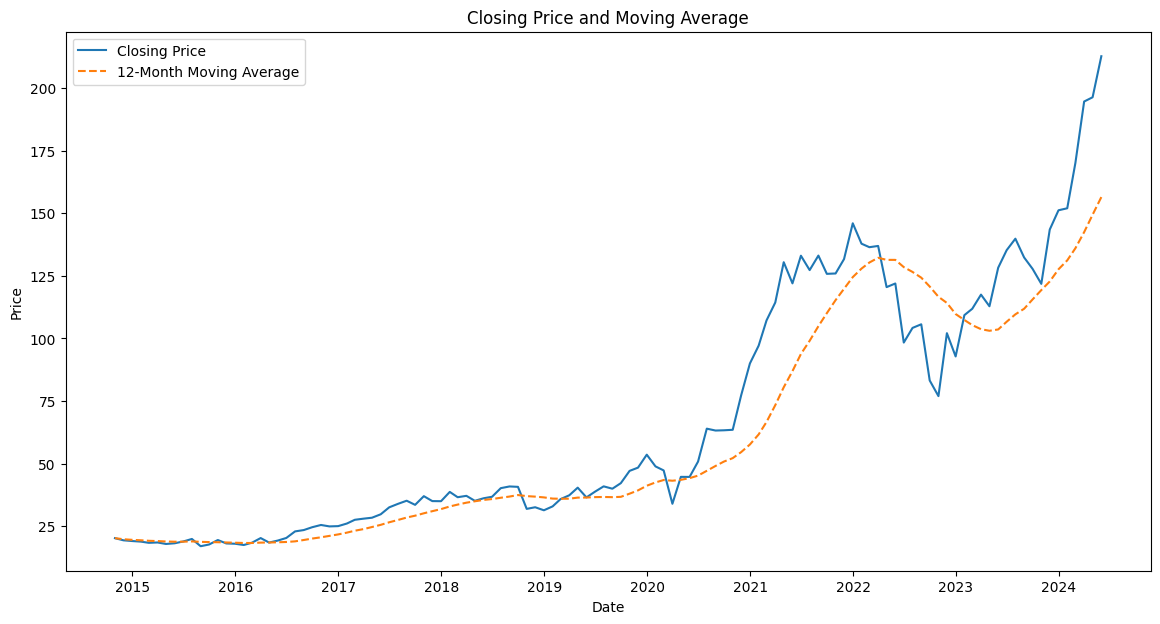

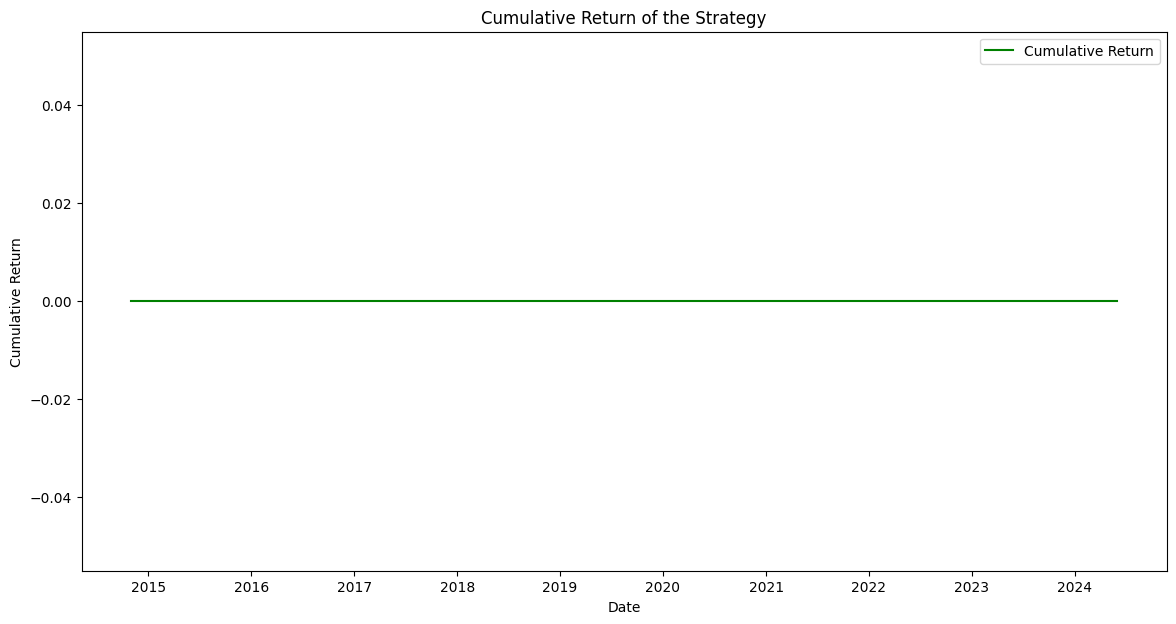

In [14]:
pandas_df = result_with_cumulative_returns.toPandas()

# Plot the closing price and moving average
plt.figure(figsize=(14, 7))
plt.plot(pandas_df['Date'], pandas_df['Close'], label='Closing Price')
plt.plot(pandas_df['Date'], pandas_df['moving_avg'], label='12-Month Moving Average', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Price and Moving Average')
plt.legend()
plt.show()

# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(pandas_df['Date'], pandas_df['cumulative_return'], label='Cumulative Return', color='green')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of the Strategy')
plt.legend()
plt.show()